# Twitter US Airline Sentiment - Part II: Building Models
## Xin (Andrew) Wei, PhD Candidate
### March 21, 2019
-  This part builds deep learning / machine learning models (ULMFiT and Logistic Regression) to analyze travelers' feelings based on their posted tweet texts, and compare results from different models
-  Main tools used: Python 3, Pandas, REs, NLTK, Scikit-Learn, fastai

## Importing Dataset

In [1125]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 100)

In [1450]:
df = pd.read_csv("./Tweets.csv")
df = df[['text', 'airline_sentiment']]

In [1204]:
df.head(n=10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


In [1203]:
df.tail(n=10)

,text,airline_sentiment
14630,@AmericanAir Thanks! He is.,positive
14631,@AmericanAir thx for nothing on getting us out of the country and back to US. Broken plane? Come on. Get another one.,negative
14632,"“@AmericanAir: @TilleyMonsta George, that doesn't look good. Please follow this link to start the refund process: http://t.co/4gr39s91Dl”😂",neutral
14633,"@AmericanAir my flight was Cancelled Flightled, leaving tomorrow morning. Auto rebooked for a Tuesday night flight but need to arrive Monday.",negative
14634,@AmericanAir right on cue with the delays👌,negative
14635,@AmericanAir thank you we got on a different flight to Chicago.,positive
14636,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc,negative
14637,@AmericanAir Please bring American Airlines to #BlackBerry10,neutral
14638,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",negative
14639,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,neutral


From the text column, we see that tweets mainly contain words, digits, punctuations, mentions (start with @ symbol), URLs (start with http), emojis, and emoticons. I will preprocess each kind of them respectively before extracting features from the tweets.

## Data Preprocessing

In [1205]:
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
import emoji

In [1227]:
def multiple_replace(dic, text):
    """ Replace in 'text' all occurrences of any key in the given
    dictionary by its corresponding value. Return the new string.
    
    dic: dictionary, with keys to be replaced and values as replacements
    text: string, matched pattern will be replaced
    return: string, new string after replacement
    """ 
    pattern = '(%s)' % '|'.join(map(re.escape, dic.keys()))
    return re.sub(pattern, lambda match: dic[match.group()], text)

In [1451]:
class textPreprocessing:
    """ Preprocess the raw text to obtain cleaned text which will be used for feature extraction.
    """
    def emoji_towords(self, text):
        # demojize emojis & insert spaces to separate emojis apart
        demojized = re.sub(r'[:️:]([\w\-\_]+)[:️:]', r' \1 ', emoji.demojize(text))
        demojized = re.sub('[-_]', '', demojized) # remove '-', '_' so that words in emojis are concatenated
        # replace common emoticons with words & insert spaces
        emoticon = dict.fromkeys([':)', ':-)', ';)', ';-)', ':-D', ':D', ';p'], ' smileyface ')
        emoticon.update(dict.fromkeys([':(', ':-(', ';(', ';-(', ":'("], ' sadface '))
        return multiple_replace(emoticon, demojized)
    
    def remove_urls(self, text):
        return re.sub(r'https?://[^\s]+', ' ', text)
    
    def remove_digits(self, text):
        return re.sub(r'[\d]+', ' ', text)
    
    def remove_punctuation(self, text):
        puncts = list(string.punctuation) + ['“', '”']
        # I think these three punctuations might indicate sentiments, so I keep them in the whitelist.
        whitelist = ['!', '?', '$']
        puncts = ''.join([punc for punc in puncts if punc not in whitelist])
        sub = str.maketrans(puncts, ' '*len(puncts))
        punct_removed = text.translate(sub)
        return re.sub('([!?$])', r' \1 ', punct_removed) # insert spaces to make each !,?,$ as separate token
    
    def to_lower(self, text):
        return text.lower()
    
    def remove_stopwords(self, text): # disable this improves 1~2% accuracy
        domainlist = ['flight', 'plane', 'airline', 'travel', 'american', 'airport', 'air', 'aircraft', 'jet', 'twitter']
        # domainlist = []
        stopwords_list = stopwords.words('english') + domainlist
        # In my opinion, the following words might indicate certain sentiments, so I keep them via a whitelist.
        whitelist = ["n't", 'not', 'no', 'but', 'after', 'before', 'when', 'why']
        words = text.split() 
        meaningful_words = [word for word in words if (word not in stopwords_list or word in whitelist)] 
        return ' '.join(meaningful_words) 
    
    def stemming(self, text):
        porter = PorterStemmer()
        words = text.split()
        stemmed = [porter.stem(word) for word in words]
        return ' '.join(stemmed)
    
    def lemmatize(self, text):
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        lemmatized = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized)

    def apply_all(self, text): # to be used for logistic regression and random forest model
        return text.apply(self.emoji_towords)\
                   .apply(self.remove_urls)\
                   .apply(self.remove_digits)\
                   .apply(self.remove_punctuation)\
                   .apply(self.to_lower)\
                   .apply(self.lemmatize) # apply either stemming or lemmatize
    
    def apply_ulmfit(self, text): # to be used for ULMFiT model
        # remove_punctuation & stemming/lemmatize are not applied because ULMFiT model needs to train language model
        # which captures the sequential relationship between words.
        return text.apply(self.emoji_towords)\
                   .apply(self.remove_urls)\
                   .apply(self.remove_digits)\
                   .apply(self.to_lower)

In [1353]:
cleantext = textPreprocessing()
df['text_cleaned'] = cleantext.apply_all(df['text'])

In [1234]:
df.head()

,text,airline_sentiment,text_cleaned
0,@VirginAmerica What @dhepburn said.,neutral,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,virginamerica plus added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,virginamerica today must mean need take another trip !
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,virginamerica really aggressive blast obnoxious entertainment guest face amp little recourse
4,@VirginAmerica and it's a really big bad thing about it,negative,virginamerica really big bad thing


In [1277]:
import sklearn
from sklearn.cross_validation import train_test_split

In [1354]:
## Split dataset into train/test subsets
text_train, text_test, y_train, y_test = train_test_split(df['text_cleaned'], df['airline_sentiment'], 
                                                          test_size = 0.1, random_state = 1) # 0.1 creates better accuracy
# Transform texts into a list of tweets to be used later
tweet_train, tweet_test = list(text_train), list(text_test)

## Feature Extraction & Model Training

In [1261]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from pprint import pprint
from time import time

In [1363]:
def trainer(vect, clf, parameters, text_train, y_train, text_test, y_test):
    """Build pipeline for feature extraction, model training, and evaluation.
    
    vect: type Vectorizer, which convert text documents to a matrix of token counts
    clf: type Classifier
    parameters: type dictionary, with keys of vect/clf parameters and values of grids
    text_train and text_test: array-like, shape = [n_samples, n_features]. each sample is a string
    y_train and y_test: array-like, shape = [n_samples]
    return: grid_search, contains results as its attributes available to users
    """
    
    # Define a pipeline combining a text feature extractor with a simple classifier
    pipeline = Pipeline([
           ('vect', vect),
           ('clf', clf),
    ])

    # Find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=0)

    print('Performing grid search...')
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(text_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test set accuracy with best estimator: %0.3f" % grid_search.best_estimator_.score(text_test, y_test))
    print()
    
    print("Test Set Classification Report:")
    print(classification_report(y_test, grid_search.best_estimator_.predict(text_test)))
    print("Train Set Classification Report:")
    print(classification_report(y_train, grid_search.best_estimator_.predict(text_train)))   
    return grid_search

### Logistic Regression Model

In [1364]:
vect = CountVectorizer(token_pattern=r"[!\?\$\w]+")
clf = LogisticRegression(random_state = 1, solver='newton-cg', multi_class='multinomial')
parameters = {
    'vect__min_df': (2, 3, ), # features with freq lower than the given threshold will be dropped
    'vect__ngram_range': ((1, 1), (1, 2), ), # unigrams or bigrams
    'clf__C': np.linspace(0.2, 0.25, 6), # smaller C specify stronger regularization
}

result_LR = trainer(vect, clf, parameters, tweet_train, y_train, tweet_test, y_test)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25]),
 'vect__min_df': (2, 3),
 'vect__ngram_range': ((1, 1), (1, 2))}
done in 146.217s

Best parameters set:
	clf__C: 0.22
	vect__min_df: 2
	vect__ngram_range: (1, 2)
Test set accuracy with best estimator: 0.827

Test Set Classification Report:
             precision    recall  f1-score   support

   negative       0.87      0.91      0.89       932
    neutral       0.67      0.67      0.67       302
   positive       0.83      0.70      0.76       230

avg / total       0.83      0.83      0.83      1464

Train Set Classification Report:
             precision    recall  f1-score   support

   negative       0.97      0.98      0.98      8246
    neutral       0.93      0.91      0.92      2797
   positive       0.95      0.93      0.94      2133

avg / total       0.96      0.96      0.96     13176



The accuracy based on the test set is 82.7%, which I think is pretty good. To further improve the accuracy, one can try to extract more features from the texts, for instance, word counts.

### ULMFiT Model
"[Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/pdf/1801.06146v5.pdf)" by Jeremy Howard and Sebastian Ruder, 2018. Useful online resources:
-  [Full Online Documentation](https://docs.fast.ai/)
-  [MOOC - Practical Deep Learning for Coders Lesson 4](https://course.fast.ai/videos/?lesson=4)

In [1371]:
from fastai import *
from fastai.text import *

In [1452]:
cleantext = textPreprocessing()
df['text_ulmfit'] = cleantext.apply_ulmfit(df['text'])

In [1453]:
train, test = train_test_split(df[['airline_sentiment', 'text_ulmfit']], test_size = 0.2, random_state = 1)
train, valid = train_test_split(train, test_size = 0.2, random_state = 1)
# Language model data
data_lm = TextLMDataBunch.from_df(path = "", train_df = train, valid_df = valid, test_df = test)
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = train, valid_df = valid, test_df = test, vocab=data_lm.vocab)

In [1454]:
data_clas.show_batch()

text,target
"xxbos @southwestair i had to travel to savannah , ga , once again , on an airline i do n't "" luv "" . when r u going to fly me to savannah ? pl xxrep 4 e ase xxrep 4 !",neutral
xxbos @united says @usairways is the final carrier . us air does nt have it . i want my bag ! ! ! not a claim not an i m sorry . i want my clothes ! !,negative
xxbos @jetblue need your help . i 'm moving to dc & & i want to book a one way fare on your website . it wo n't seem to let me . am i missing something ?,negative
xxbos @americanair poor experience day at ord xxunk . emp . w / cust . waiting . asked to speak w / supervisor . told min . in a mtg ! ! what ? ! ? !,negative
xxbos @united she clappinghands wo n't clappinghands be clappinghands at clappinghands my clappinghands wedding clappinghands . this is an xxunk xxunk . there 's no reflight booking problems . how can we be xxunk for this ?,negative


#### Fine-tuning Language Model

In [1455]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.5) # decrease drop_mult if underfitting
# check https://docs.fast.ai/text.learner.html

In [1456]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-02


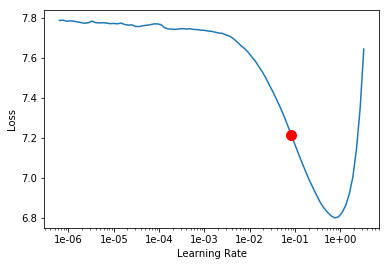

In [1457]:
learn.recorder.plot()

Optimal learning rate roughly between 1e-2 and 5e-1. I'll use 1e-2 below.

In [1434]:
learn.fit_one_cycle(1, 1e-2)
# Best: 0.2316
# 4e-1: 0.17; 1e-1:0.19; drop mom: 0.20; 1e-2: 0.2006; preprocess & -1: 0.2020; -2: 21.35%; remain digits: 16.07%
# remove digits & puncts: 14.14%; 0.1 test set: 16.50; decrease drop_mult to 0.3: 17%

epoch,train_loss,valid_loss,accuracy
1,4.845295,4.450393,0.212147


Note that accuracy is calculated on the validation set.

In [1435]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,4.536512,4.342865,0.222266
2,4.419868,4.228643,0.234896
3,4.298840,4.145951,0.242299
4,4.172734,4.108502,0.246112
5,4.037139,4.061037,0.248586
6,3.906740,4.047737,0.250223
7,3.792644,4.043410,0.251283
8,3.698390,4.044888,0.252046
9,3.640120,4.046188,0.251897
10,3.599975,4.045992,0.251563


In [1436]:
learn.save_encoder('ft_enc')

#### Training Classifier

In [1437]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

In [1438]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-01


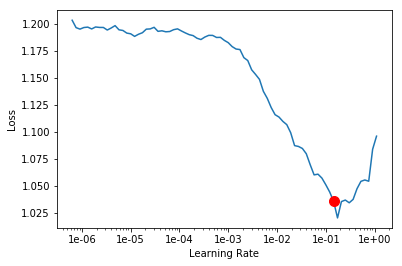

In [1439]:
learn.recorder.plot()

In [1440]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy
1,0.722841,0.585162,0.751174


In [1441]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.659375,0.531480,0.786598


In [1442]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy
1,0.595004,0.492218,0.802817


In [1443]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.590371,0.501666,0.801963
2,0.572123,0.497960,0.806231
3,0.538678,0.491926,0.807939
4,0.508636,0.482318,0.812633


Note that the accuracy 81.3% is based on validation set.

In [1447]:
## get accuracy for the test set
probs, targets = learn.get_preds(ds_type = DatasetType.Test)
preds = np.argmax(probs, axis = 1)
accuracy = (preds == targets).float().mean()
print('accuracy for the test set is: '+'{:.1%}'.format(accuracy))

accuracy for the test set is: 67.7%


In [1449]:
## Show 10 samples of predictions
learn.show_results(rows=10)

text,target,prediction
"xxbos @jetblue i redheart ️ jetblue but i was on flt from fll to sfo . xxunk off was over hr late flight , div to phx & & got in hrs late flight . what will be done ?",negative,negative
"xxbos @united so they changed depart from : to : pm & & it is now : pm & & the capt . just got off the plane to find a xxunk , pm my ass ! ! !",negative,negative
xxbos @united where is my bag ? ? i 'm in mexico about to go xxunk a house & & my suitcase never got on my flight from cle w me . i need it . san m,negative,negative
"xxbos @jetblue big shoutout to the crews on bos > jfk & & jfk > roc , & & gate crews at c bos & & jfk . long day of delays made better by them !",positive,positive
"xxbos @jetblue no , it 's weird ! ! i picked other cities just to xxunk , those worked ... not the one i want . works on phone though , so i 'll use that .",neutral,negative
xxbos @jetblue i would go to las vegas . it is xxunk and i go there every year and i fly with you guys vegas is xxunk & & so much to do there . palmtree,positive,neutral
"xxbos @united i had n't filed a refund claim as i was told there was no charge by your dm . this is xxunk by my bank , hence why i would like ( / )",negative,negative
xxbos @jetblue c'mon now . my flight 's delayed a xxrep 5 n d you ca n't give me a pick ? ! ? i 'm about to tweet at @united or @delta xxrep 7 .,negative,negative
"xxbos @americanair you did n't call , did you . try it , and then you 'll understand . it 's not possible to reach an agent , i do n't know what else to do",negative,negative
xxbos @usairways please xxunk my next flight for me ! i 'm waiting on a bus to get me off one plane so i can run to the other . it leaves in two min !,negative,negative


## Conclusions & Future Works

Conclusion:
-  Based on the test set, Logistic Regression (82.7%) achieves higher accuracy rate than ULMFiT (67.7%) model.

Future works:
-  Improve accuracy of ULMFiT model
-  Add numeric features such as word counts of tweets as additional features
-  Add bigram of words such as "customer service" to take into account the sequential relationship between words. Can probably be done via NLTK